In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx


from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer


In [2]:
sns.set_style("ticks")

In [3]:
# Load data

train = pd.read_csv('./data/train.csv')
greeks = pd.read_csv('./data/greeks.csv')
test = pd.read_csv('./data/test.csv')

In [4]:
# Set index

train = train.set_index('Id')
test = test.set_index('Id')
greeks = greeks.set_index('Id')

# Separate target and features
X = train.drop('Class', axis = 1)
y = train['Class']

<h3><center> Data Organization / Cleaning </center></h3>

In [5]:
# Get features list
violin_features = list(X.columns)
categorial_features = X.columns[X.dtypes != float].values.tolist()

# Remove non-float features
violin_features.remove(*categorial_features)

print(categorial_features)

['EJ']


One-hot encoding for 'EJ' categorial feature

In [6]:
# Encode categorial object 'EJ' feature 

enc = OneHotEncoder()
enc.fit(X['EJ'].values.reshape(-1, 1))
onehot_cols = ['EJ' + '_' + x for x in enc.categories_[0]]

X[onehot_cols] = enc.transform(X['EJ'].values.reshape(-1, 1)).toarray()
X = X.drop('EJ', axis = 1)

#test[onehot_cols] = enc.transform(test['EJ'].values.reshape(-1, 1)).toarray()
#test = test.drop('EJ', axis = 1)

#violin_features.extend(onehot_cols)

Check and fill missing values using KNN Imputer

In [7]:
# Check which features are missing and how many missing data points are there

nas = X.isnull().sum()[X.isnull().sum() > 0]
nas

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [8]:
# Since the features which contain missing values are not normally-distributed, we will use iterative imputer. 

imp = KNNImputer() # weight by distance but use many neighbors
X2 = pd.DataFrame(imp.fit_transform(X), index = X.index, columns = X.columns)

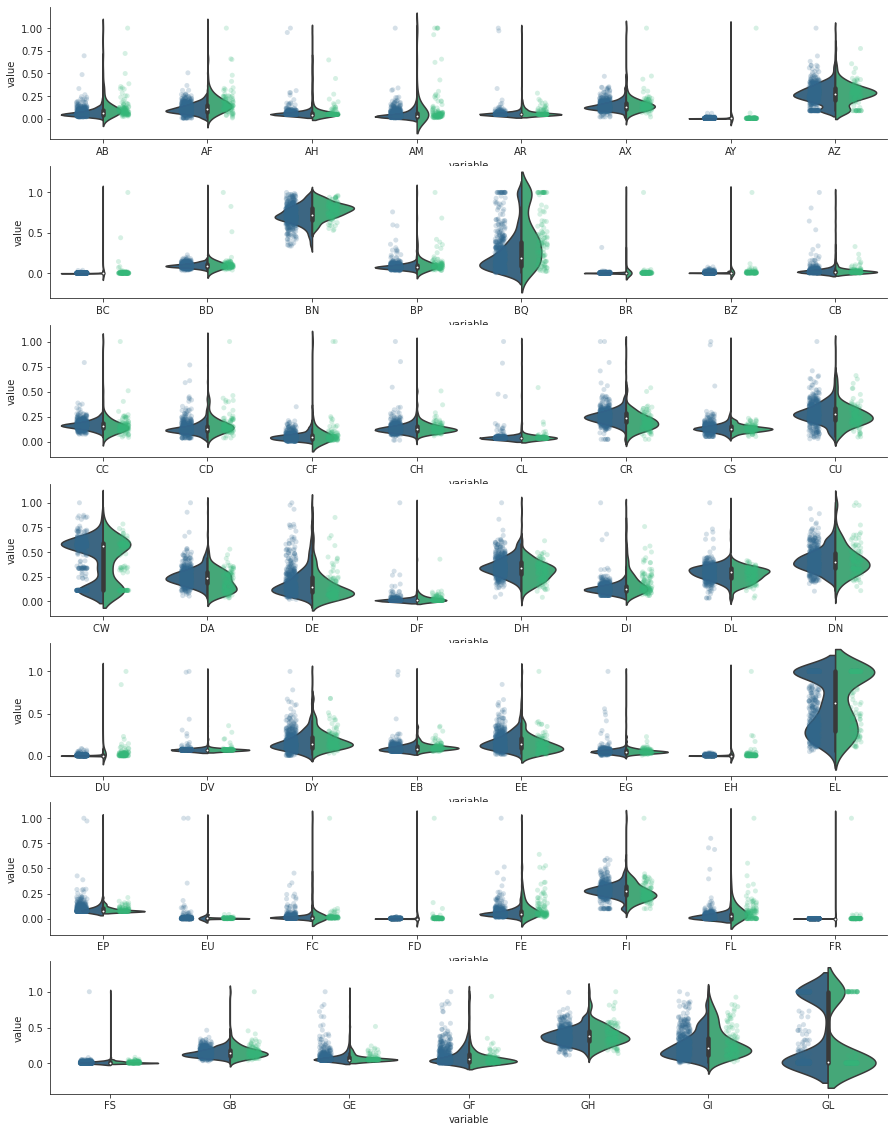

In [9]:
# Plot violin plots of non-categorial features

fig, axs = plt.subplots(nrows = 7, ncols = 1, figsize = (15, 20))

axs = np.ravel(axs)

for row in range(7):
    features = violin_features[row*8:(row+1)*8]
    #df_plot = pd.concat([X2[features], y], axis = 1)
    df_plot = pd.concat([X2[features], y], axis = 1)
    df_plot = df_plot / df_plot.max(axis = 0) # Normalize them for plotting purposes
    df_plot = df_plot.melt(id_vars = ['Class'], value_vars = features)
    sns.violinplot(data = df_plot, x = 'variable', y = 'value', hue = 'Class', split = True,palette = 'viridis', ax = axs[row])
    sns.stripplot(data = df_plot, x = 'variable', y = 'value', hue = 'Class', dodge = True,palette = 'viridis', alpha = 0.2, ax = axs[row])
    axs[row].get_legend().remove()
sns.despine()
#plt.tight_layout()

Semi-insights:
*Highly concentrated AY, BC, BR, BZ, DU, EH, EU, FR  <br>
* Large AM -> Highly likely Green <br>
* Large CR -> Slightly likely blue <br>
* Large DH -> Slightly likely blue <br>
* Large DA -> Slightly likely blue <br>
* Large EE -> Slightly likely blue <br>
* Large FI -> Slightly likely blue <br>
<br>

Before studying the correlations, let us complete the missing values.

In [10]:
# Plot categorial

In [11]:
df_corr = X2.corr().abs()
corr_pairs = df_corr.unstack().dropna().sort_values(ascending=False)
selected_corr_pairs = corr_pairs[(corr_pairs < 1) & (corr_pairs > 0.75)]
selected_corr_pairs = selected_corr_pairs.iloc[::2] # drop the identical 
selected_corr_pairs

GL    EJ_A    0.978148
EJ_B  GL      0.978148
EH    FD      0.971152
DV    CL      0.948991
BC    BZ      0.907981
EH    DU      0.850953
DV    AR      0.823012
FD    DU      0.805990
CS    EP      0.794158
EP    AR      0.754615
BC    BD      0.753051
dtype: float64

Spaces?

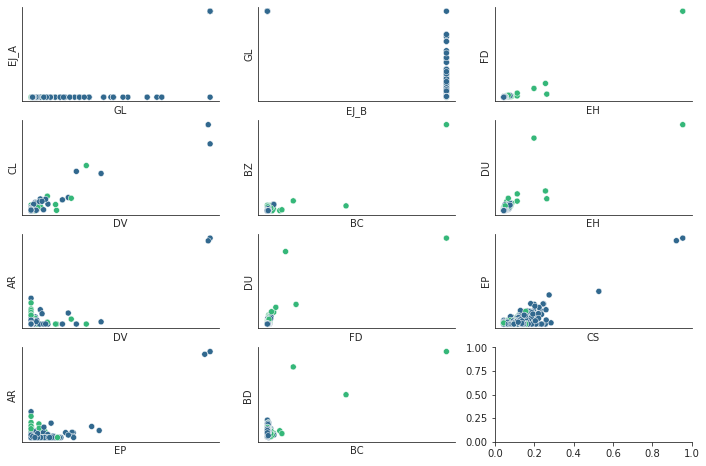

In [12]:
# Plot calibration plots of highly correlated categorial features

fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (12, 8))

axs = np.ravel(axs)

for i, pair in enumerate(selected_corr_pairs.index):
    f1, f2 = pair
    sns.scatterplot(data = pd.concat([X2[[f1, f2]], y], axis = 1), x = f1, y = f2, hue = 'Class', ax = axs[i], palette='viridis')
    #sns.regplot(data = train[[f1, f2, 'Class']], x = f1, y = f2, ax = axs[i])

    axs[i].get_legend().remove()
    axs[i].set_xticks([])
    axs[i].set_yticks([])
sns.despine()


In [13]:
df_categorial = train[['GL', 'EJ', 'Class']]


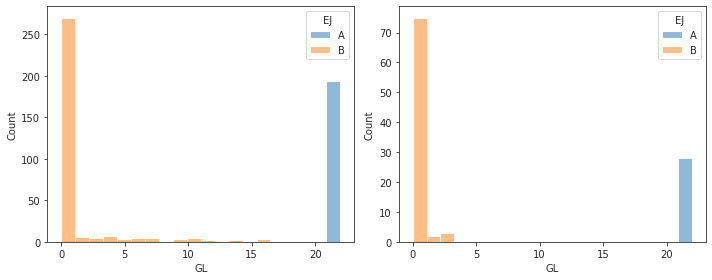

In [14]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 4))
sns.histplot(data = train[train['Class'] == 0], x = 'GL', hue = 'EJ', ax = ax[0], hue_order = ['A', 'B'], bins = 20)
sns.histplot(data = train[train['Class'] == 1], x = 'GL', hue = 'EJ', ax = ax[1], hue_order = ['A', 'B'], bins = 20)
plt.tight_layout()

In [15]:
print('Value count with GL over 18\n',train.loc[train['GL'] >= 18, "EJ"].value_counts())
print('Value count with GL under 18\n',train.loc[train['GL'] < 18, "EJ"].value_counts())

Value count with GL over 18
 A    222
B      1
Name: EJ, dtype: int64
Value count with GL under 18
 B    393
Name: EJ, dtype: int64


In [16]:
print('The single value with B ('+train.loc[(train['GL'] > 18) & (train['EJ'] == 'B')].index[0]+') is not the same as the missing value in GL ('+X['GL'][X['GL'].isnull()].index[0]+')')

The single value with B (38325b0c36e5) is not the same as the missing value in GL (f46e39a96ee9)


Thus, smaller GL will be always in Class B, and larger A will always be in class A. 
<br>
Let us map the correlated features in a network.

In [17]:
selected_corr_pairs = corr_pairs[(corr_pairs < 1) & (corr_pairs > 0.6)]
selected_corr_pairs = selected_corr_pairs.iloc[::2] # drop the identical 
selected_corr_pairs
G = nx.DiGraph(selected_corr_pairs.index.to_list())

In [18]:
def generate_points_on_circle(nodes, radius=1):
    points = {}
    num_points = len(nodes)
    for i in range(num_points):
        angle = 2 * np.pi * i / num_points
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        points[nodes[i]] = (x, y)
    return points

# Generate 15 points on the circle with radius 1
points_on_circle = generate_points_on_circle(list(list(G.nodes())))


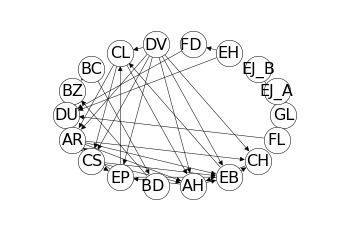

In [19]:
params = {
    "font_size": 16,
    "node_size": 700,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 0.5,
    "width": 0.5,
}
nx.draw_networkx(G, points_on_circle, **params)
ax = plt.gca()
ax.margins(0.2)
plt.axis("off")
plt.show()

In [20]:
# Add clusters

<h3><center> Initial Modeling </center></h3>

In [21]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler


In [42]:
skf = StratifiedShuffleSplit(n_splits=5, test_size=0.35, random_state=42)

In [43]:
rf_params = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [2, 4 ,8],}
 #'class_weight': 'balanced_subsample'} # [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [44]:
score = {}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):  
    # Split
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Add missing values
    imp = KNNImputer(weights = 'distance', n_neighbors=20).fit(X_train)

    X_train = pd.DataFrame(imp.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_test = pd.DataFrame(imp.transform(X_test), index = X_test.index, columns = X_test.columns)

    # Scale data
    scaler = StandardScaler().fit(X_train)

    X_train = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

    rf = RandomizedSearchCV(RandomForestClassifier(), rf_params, n_iter = 30, cv = skf.split(X_train, y_train))
    rf.fit(X_train, y_train)

    train_score = rf.score(X_train, y_train)
    test_score = rf.score(X_test, y_test)

    score[i] = [train_score, test_score]

    

In [45]:
score

{0: [0.9900249376558603, 0.9120370370370371],
 1: [0.9925187032418953, 0.8796296296296297],
 2: [0.9675810473815462, 0.8657407407407407],
 3: [0.9800498753117207, 0.9074074074074074],
 4: [0.9975062344139651, 0.8518518518518519]}